# Multitask Learning

Use a single shared representation to predict gender and phase 2

### Load Embeddings and Abstracts

In [1]:
%store -r embeddings_info

abstracts = embeddings_info['abstracts']
abstracts_padded = embeddings_info['abstracts_padded']
embeddings = embeddings_info['embeddings']
word_dim = embeddings_info['word_dim']
word2idx, idx2word = embeddings_info['word2idx'], embeddings_info['idx2word']
maxlen = embeddings_info['maxlen']
vocab_size = embeddings_info['vocab_size']

### Load Labels

In [27]:
%store -r pruned_dataset binarized_dataset

ys = np.array(binarized_dataset).T

from support import classinfo_generator, produce_labels

labels = pruned_dataset.columns.tolist()
class_info = list(classinfo_generator(pruned_dataset))
class_names, class_sizes = zip(*class_info)
class_names = {label: classes for label, classes in zip(labels, class_names)}

data = dict(produce_labels(labels, class_sizes, ys))
data.update({'input': abstracts_padded})

val_dict = {label: y_row for label, y_row in zip(labels, ys)}
val_dict.update({'input': abstracts_padded})

### Hyperparameters

In [3]:
nb_filter = 20
filter_length = 2
hidden_dims = 32
nb_epoch = 35
batch_size = 10

### Define Model

In [4]:
from keras.models import Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D

model = Graph()
model.add_input(name='input', input_shape=[maxlen], dtype='int') # dtype='int' is 100% necessary for some reason!
model.add_node(Embedding(input_dim=vocab_size, output_dim=word_dim, weights=[embeddings], input_length=maxlen, trainable=False),
               name='embedding', input='input')
model.add_node(Dropout(0.25), name='dropout1', input='embedding')

model.add_node(Convolution1D(nb_filter=nb_filter,
                             filter_length=filter_length,
                             activation='relu'),
              name='conv',
              input='dropout1')
model.add_node(MaxPooling1D(pool_length=maxlen-1), name='pool', input='conv') # non-maximum suppression
model.add_node(Flatten(), name='flat', input='pool')
model.add_node(Dense(hidden_dims), name='z', input='flat')
model.add_node(Activation('relu'), name='shared', input='z')
model.add_node(Dropout(0.25), name='dropout2', input='shared')

# Fork the graph and predict probabilities for each target from shared representation
for label, num_classes in zip(labels, class_sizes):
    model.add_node(Dense(output_dim=num_classes, activation='softmax'), name='{}_probs'.format(label), input='dropout2')
    model.add_output(name=label, input='{}_probs'.format(label))

model.compile(optimizer='rmsprop',
              loss={label: 'categorical_crossentropy' for label in labels}) # CE for all the targets

Using Theano backend.
/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


### Define Callback

In [72]:
import keras

class AccuracyCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, val_dict, batch_size, num_train, val_every):
        """Callback to compute accuracy during training
        
        Parameters
        ----------
        validation : dict of data expected by graph.predict()
        val_dict : dict from labels to classes
        batch_size : number of examples per batch
        num_train : number of examples in training set
        val_every : number of times to to validation during an epoch
        
        """
        self.validation_data = validation_data
        self.val_dict = val_dict
        self.num_batches_since_val = 0
        num_minis_per_epoch = (num_train/batch_size) # number of minibatches per epoch
        self.K = num_minis_per_epoch / val_every # number of batches to go before doing validation
        
        super(AccuracyCallback, self).__init__()
        
    def on_batch_end(self, batch, logs={}):
        """Do validation if it's been a while
        
        Specifically, """
        
        if self.num_batches_since_val < self.K-1:
            self.num_batches_since_val += 1
            return
            
        predictions = self.model.predict(self.validation_data)
        
        print
        for label, ys_pred in predictions.items():
            print '{} accuracy:'.format(label), np.mean(ys_pred.argmax(axis=1) == self.val_dict[label])
            
        self.num_batches_since_val = 0

### Training

In [73]:
batch_size = 6
num_epochs = 10

callback = AccuracyCallback(data, val_dict, batch_size, num_train=len(abstracts_padded), val_every=2)
checkpointer = keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", verbose=1)

history = model.fit(data, validation_data=data, batch_size=batch_size, callbacks=[callback, checkpointer], nb_epoch=10)

Train on 50 samples, validate on 50 samples
Epoch 1/10
24/50 [=============>................] - ETA: 0s - loss: 0.5628
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
48/50 [===========================>..] - ETA: 0s - loss: 0.5856
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.5701 - val_loss: 0.4096
Epoch 00000: saving model to weights.hdf5
Epoch 2/10
18/50 [=========>....................] - ETA: 0s - loss: 0.6675
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
42/50 [========================>.....] - ETA: 0s - loss: 0.5576
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.5661 - val_loss: 0.4051
Epoch 00001: saving model to weights.hdf5
Epoch 3/10
12/50 [======>.......................] - ETA: 0s - loss: 0.5332
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accurac

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/keras/callbacks.py:67: UserWarning: Method on_batch_end() is slow compared to the batch update (0.350217). Check your callbacks.
  % delta_t_median)
/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/keras/callbacks.py:67: UserWarning: Method on_batch_end() is slow compared to the batch update (0.703228). Check your callbacks.
  % delta_t_median)



gender accuracy: 0.94
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
30/50 [=================>............] - ETA: 0s - loss: 0.4581
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
48/50 [===========================>..] - ETA: 0s - loss: 0.5466
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.5373 - val_loss: 0.3717
Epoch 00003: saving model to weights.hdf5
Epoch 5/10
24/50 [=============>................] - ETA: 0s - loss: 0.7318
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
48/50 [===========================>..] - ETA: 0s - loss: 0.5238
gender accuracy: 0.96
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.5073 - val_loss: 0.3520
Epoch 00004: saving model to weights.hdf5
Epoch 6/10
18/50 [=========>....................] - ETA: 0s - loss: 0.4753
gender accuracy: 0.94
ec_safety_study accuracy:

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/keras/callbacks.py:67: UserWarning: Method on_batch_end() is slow compared to the batch update (0.351961). Check your callbacks.
  % delta_t_median)
/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/keras/callbacks.py:67: UserWarning: Method on_batch_end() is slow compared to the batch update (0.345528). Check your callbacks.
  % delta_t_median)



gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
36/50 [====================>.........] - ETA: 0s - loss: 0.5665
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.5994 - val_loss: 0.3274
Epoch 00006: saving model to weights.hdf5
Epoch 8/10
 6/50 [==>...........................] - ETA: 0s - loss: 0.1426
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
12/50 [======>.......................] - ETA: 2s - loss: 0.2264

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/keras/callbacks.py:67: UserWarning: Method on_batch_end() is slow compared to the batch update (0.705337). Check your callbacks.
  % delta_t_median)
/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/keras/callbacks.py:67: UserWarning: Method on_batch_end() is slow compared to the batch update (0.352977). Check your callbacks.
  % delta_t_median)


30/50 [=================>............] - ETA: 0s - loss: 0.4041
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
48/50 [===========================>..] - ETA: 0s - loss: 0.4906
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.4746 - val_loss: 0.3199
Epoch 00007: saving model to weights.hdf5
Epoch 9/10
24/50 [=============>................] - ETA: 0s - loss: 0.4347
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
48/50 [===========================>..] - ETA: 0s - loss: 0.5871
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
50/50 [==============================] - 3s - loss: 0.5678 - val_loss: 0.3168
Epoch 00008: saving model to weights.hdf5
Epoch 10/10
18/50 [=========>....................] - ETA: 0s - loss: 0.6300
gender accuracy: 0.98
ec_safety_study accuracy: 1.0
phase_2 accuracy: 1.0
42/50 [========================>.....] - ETA: 0

### Confusion Matrix

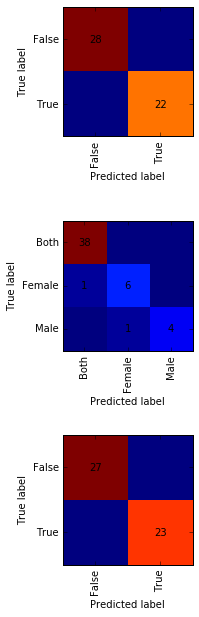

In [70]:
from sklearn.metrics import confusion_matrix
from support import plot_confusion_matrix

X_val = abstracts_padded

predictions = model.predict({'input': X_val})

fig = plt.figure(figsize=(10,10))
plt.clf()

for i, label in enumerate(labels, start=1):
    axes = fig.add_subplot(len(labels), 1, i)
    
    y_row, y_pred = val_dict[label], predictions[label]
    
    cm = confusion_matrix(y_row, y_pred.argmax(axis=1))
    plot_confusion_matrix(cm, class_names[label])
    
    fig.subplots_adjust(wspace=.35, hspace=.65)

### Examine Bigrams Which Filters Fire on

In [71]:
filters = model.nodes['conv'].W.eval()
filters = np.squeeze(filters)
filters = [filter.T for filter in filters]

def activation_generator(filter, abstract):
    for w1, w2 in zip(abstract, abstract[1:]):
        yield np.sum(embeddings[[w1, w2]] * filter), (w1, w2)
        
def activations_generator(filters, abstract):
    for filter in filters:
        yield list(activation_generator(filter, abstract))
        
def show_activations(filters, abstract):
    activations = list(activations_generator(filters, abstract))

    for activation in activations:
        for score, (w1, w2) in sorted(activation, reverse=True)[:10]:
            print score, idx2word[w1], idx2word[w2]

        print

for idx in [0, 2, 7, 9, 10]:
    print abstracts[idx]
    print
    for label, symbol in zip(labels, ys[:, idx]):
        print label, class_names[label][symbol]
    print
    
    show_activations(filters, abstracts_padded[idx])

D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo treatment on any primary outcome mea